In [15]:
import numpy as np
from PIL import Image
from sklearn.feature_extraction import image
import matplotlib.pyplot as plt

In [112]:
# Import images and get black and white and color representation as arrays
citrus = Image.open('coins.png')
citrusColor = np.asarray(citrus)
citrusBW = []
for row in citrusColor: 
    newRow = []
    for entry in row: 
        newRow.append(0.3*entry[0] + 0.59*entry[1] + 0.11*entry[2])
    citrusBW.append(np.asarray(newRow))
citrusBW = np.asarray(citrusBW)

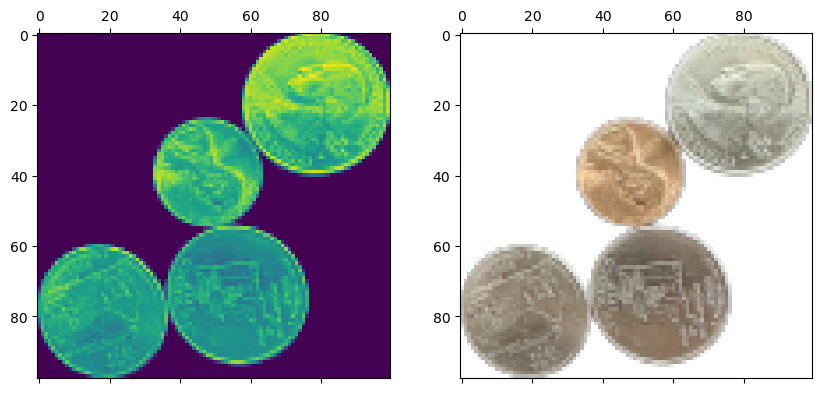

In [113]:
# Display images below
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(citrusBW)
axs[1].matshow(citrusColor)
plt.show()

In [114]:
imgMask = []
for row in citrusColor: 
    newRow = []
    for entry in row: 
        newRow.append(entry[3] > 50)
    imgMask.append(np.asarray(newRow))
imgMask = np.asarray(imgMask)

In [115]:
graph = image.img_to_graph(citrusBW, mask = imgMask)

In [121]:
from sklearn.cluster import spectral_clustering
import matplotlib.pyplot as plt

labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(imgMask.shape, -1.0)
label_im[imgMask] = labels

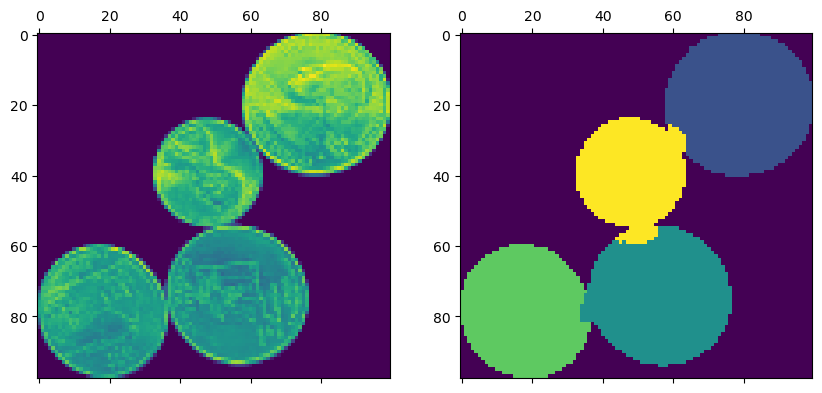

In [122]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(citrusBW)
#axs[1].matshow(imgMask)
axs[1].matshow(label_im)
plt.show()

Preliminary results generated from only using black and white images to find the min cut. However, this only relies on the difference in value, black and white so it doesn't account for the difference in color. Since the graph's edges are determined by the difference in pixels, instead of looking at difference in value, look at the difference in color, norm of difference. 

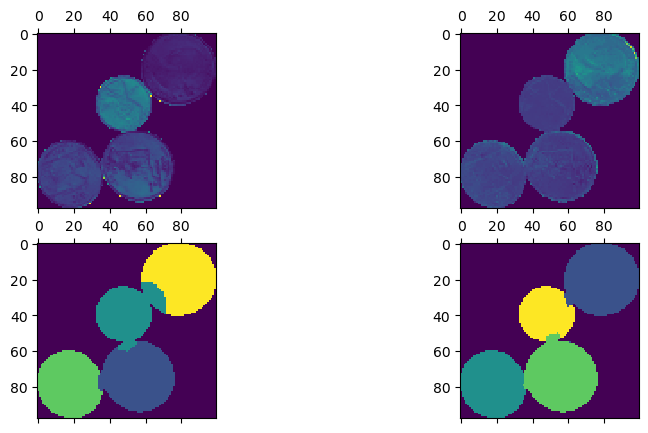

In [119]:
import colorsys
#get only saturation
citrusS = []
citrusH = []
for row in citrusColor: 
    newRowS = []
    newRowH = []
    for entry in row: 
        (h,s,v) = colorsys.rgb_to_hsv(entry[0]/255, entry[1]/255, entry[2]/255)
        newRowS.append(s)
        newRowH.append(h)
    citrusS.append(np.asarray(newRowS))
    citrusH.append(np.asarray(newRowH))
citrusS = np.asarray(citrusS)
citrusH = np.asarray(citrusH)

citrusSGraph = image.img_to_graph(citrusS, mask = imgMask)
citrusHGraph = image.img_to_graph(citrusH, mask = imgMask)

labelsS = spectral_clustering(citrusSGraph, n_clusters=4, eigen_solver="arpack")
label_imS = np.full(imgMask.shape, -1.0)
label_imS[imgMask] = labelsS

labelsH = spectral_clustering(citrusHGraph, n_clusters=4, eigen_solver="arpack")
label_imH = np.full(imgMask.shape, -1.0)
label_imH[imgMask] = labelsH

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axs[0][0].matshow(citrusS)
axs[0][1].matshow(citrusH)
axs[1][0].matshow(label_imS)
axs[1][1].matshow(label_imH)
plt.show()

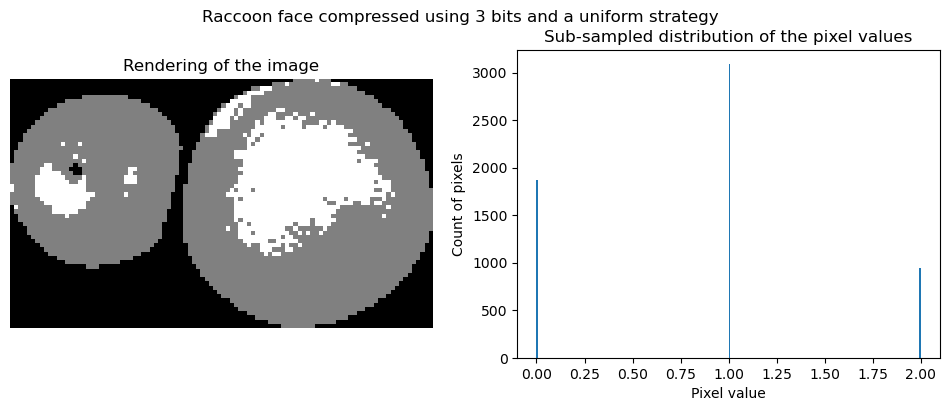

In [99]:
from sklearn.preprocessing import KBinsDiscretizer

n_bins = 3
encoder = KBinsDiscretizer(
    n_bins=n_bins, encode="ordinal", strategy="uniform", random_state=0
)
compressed_citrusBW_uniform = encoder.fit_transform(citrusBW.reshape(-1, 1)).reshape(
    citrusBW.shape
)
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].imshow(compressed_citrusBW_uniform, cmap=plt.cm.gray)
ax[0].axis("off")
ax[0].set_title("Rendering of the image")
ax[1].hist(compressed_citrusBW_uniform.ravel(), bins=256)
ax[1].set_xlabel("Pixel value")
ax[1].set_ylabel("Count of pixels")
ax[1].set_title("Sub-sampled distribution of the pixel values")
_ = fig.suptitle("Raccoon face compressed using 3 bits and a uniform strategy")

In [86]:
graph.get_shape()

(4156, 4156)

In [94]:
def imgToGraph(pic, difference):
    imgAsAdjacencyMatrix = []
    x = len(citrusColor[0])
    y = len(citrusColor)
    for i in range(x):
        for j in range(y):
            if imgMask[i][j]:
                newRow = []
                for k in range(x):
                    for l in range(y):
                        if imgMask[k][l]:
                            newRow.append(difference(pic[i][j],pic[k][l]))
                imgAsAdjacencyMatrix.append(np.asarray(newRow))
    return np.asarray(imgAsAdjacencyMatrix)


In [95]:
graph = image.img_to_graph(citrusBW)

In [96]:
graph2 = imgToGraph(citrusBW, lambda x,y: x-y)

IndexError: index 59 is out of bounds for axis 0 with size 59

In [ ]:
lambda x,y:np.linalg.norm(np.subtract(x,y))

In [50]:
graph[0]

TypeError: 'coo_matrix' object is not subscriptable

In [51]:
type(graph)

scipy.sparse.coo.coo_matrix